### **Import Libraries for running codes**

In [ ]:
import os

import torch
from torch import nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import scipy.stats as ss # 통계관련
from torchvision.datasets import MNIST, FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import random
import matplotlib.pyplot as plt
import time
import pandas as pd # 데이터베이스 관련

##**Download MNIST dataset and pre-processing**


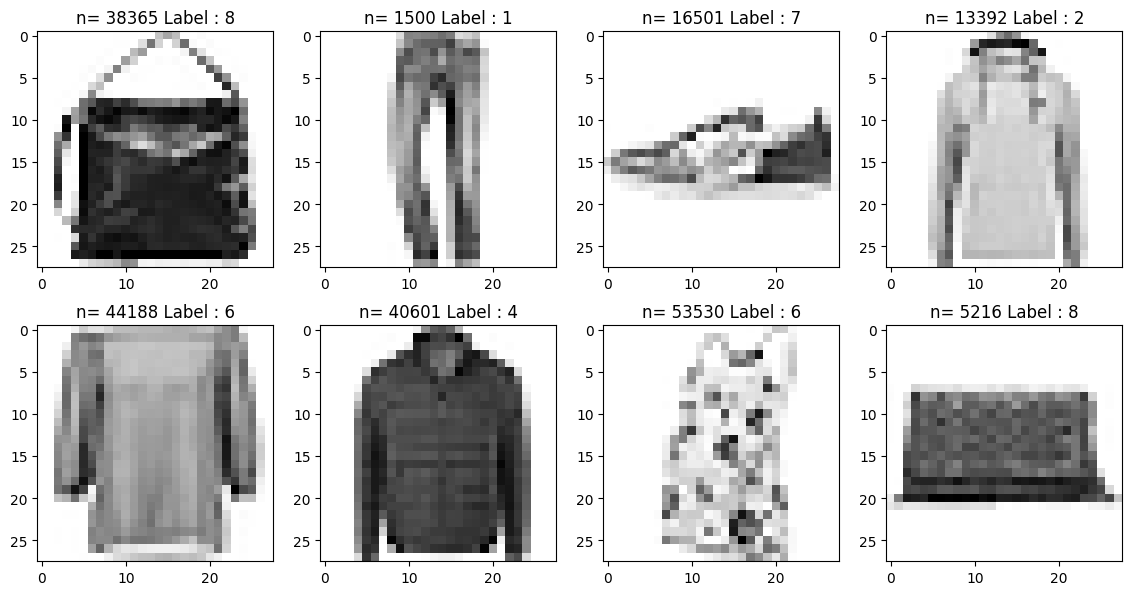

In [ ]:
"""MNIST"""
# dataset_path = './datasets/MNIST'
# ds_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((28, 28)), transforms.Normalize((0.130,), (0.3081))])
# ds_transform = transforms.ToTensor()
# train_ds = MNIST(dataset_path, transform=ds_transform, train=True, download=True)
# test_ds = MNIST(dataset_path, transform=ds_transform, train=False, download=True)

"""Fashion-MNIST"""
dataset_path = './datasets/FashionMNIST'
ds_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((28, 28)), transforms.Normalize((0.5,), (0.5))])
train_ds = FashionMNIST(dataset_path, transform=ds_transform, train=True, download=True)
test_ds = FashionMNIST(dataset_path, transform=ds_transform, train=False, download=True)

train_bs = 1024
test_bs = 10000

'''fix random seed''' # 재현성 검토를 위해
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)

train_dl = DataLoader(dataset=train_ds, batch_size=train_bs, shuffle=False)
test_dl = DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False)

"""plot random data"""
samples = random.choices(population=range(0, len(train_ds)), k=8)
plt.figure(figsize=(14,7))
for idx, n in enumerate(samples):
    plt.subplot(2,4,idx+1)
    plt.imshow(train_ds[n][0].reshape(28, 28), cmap='Greys', interpolation='nearest')
    plt.title('n= '+str(n)+' Label : ' + str(train_ds[n][1]))
    # plt.axis('off')
# print(test_ds[0][0])

##**Set hyper-parameters**

In [ ]:
epoch = 40
# v_plus = 0.20
# v_minus = -0.20
# num_states = 30

v_plus = 0.005
v_minus = -0.020
num_states = 100



'''stoch = 10: 90%, =5: 80%'''
stochastic_update = 0.9   # 0.9 -> 전체 weight의 90%만 원래대로 업데이트, threshold 전에 적용됨.

# init_std = 15
init_std = 0.1 # weight 초기값 설정시 norm(mean=0,std=?)에서 표준편차를 전체 num_states의 몇 %로 잡을지

grad_threshold_fc1 = 0.001
grad_threshold_fc2= 0.001

device = 'cuda' if torch.cuda.is_available() else 'cpu'

##**Define util functions**

"""Based on the parameters of non-linear coefficient, create the fitting curve of conductance"""
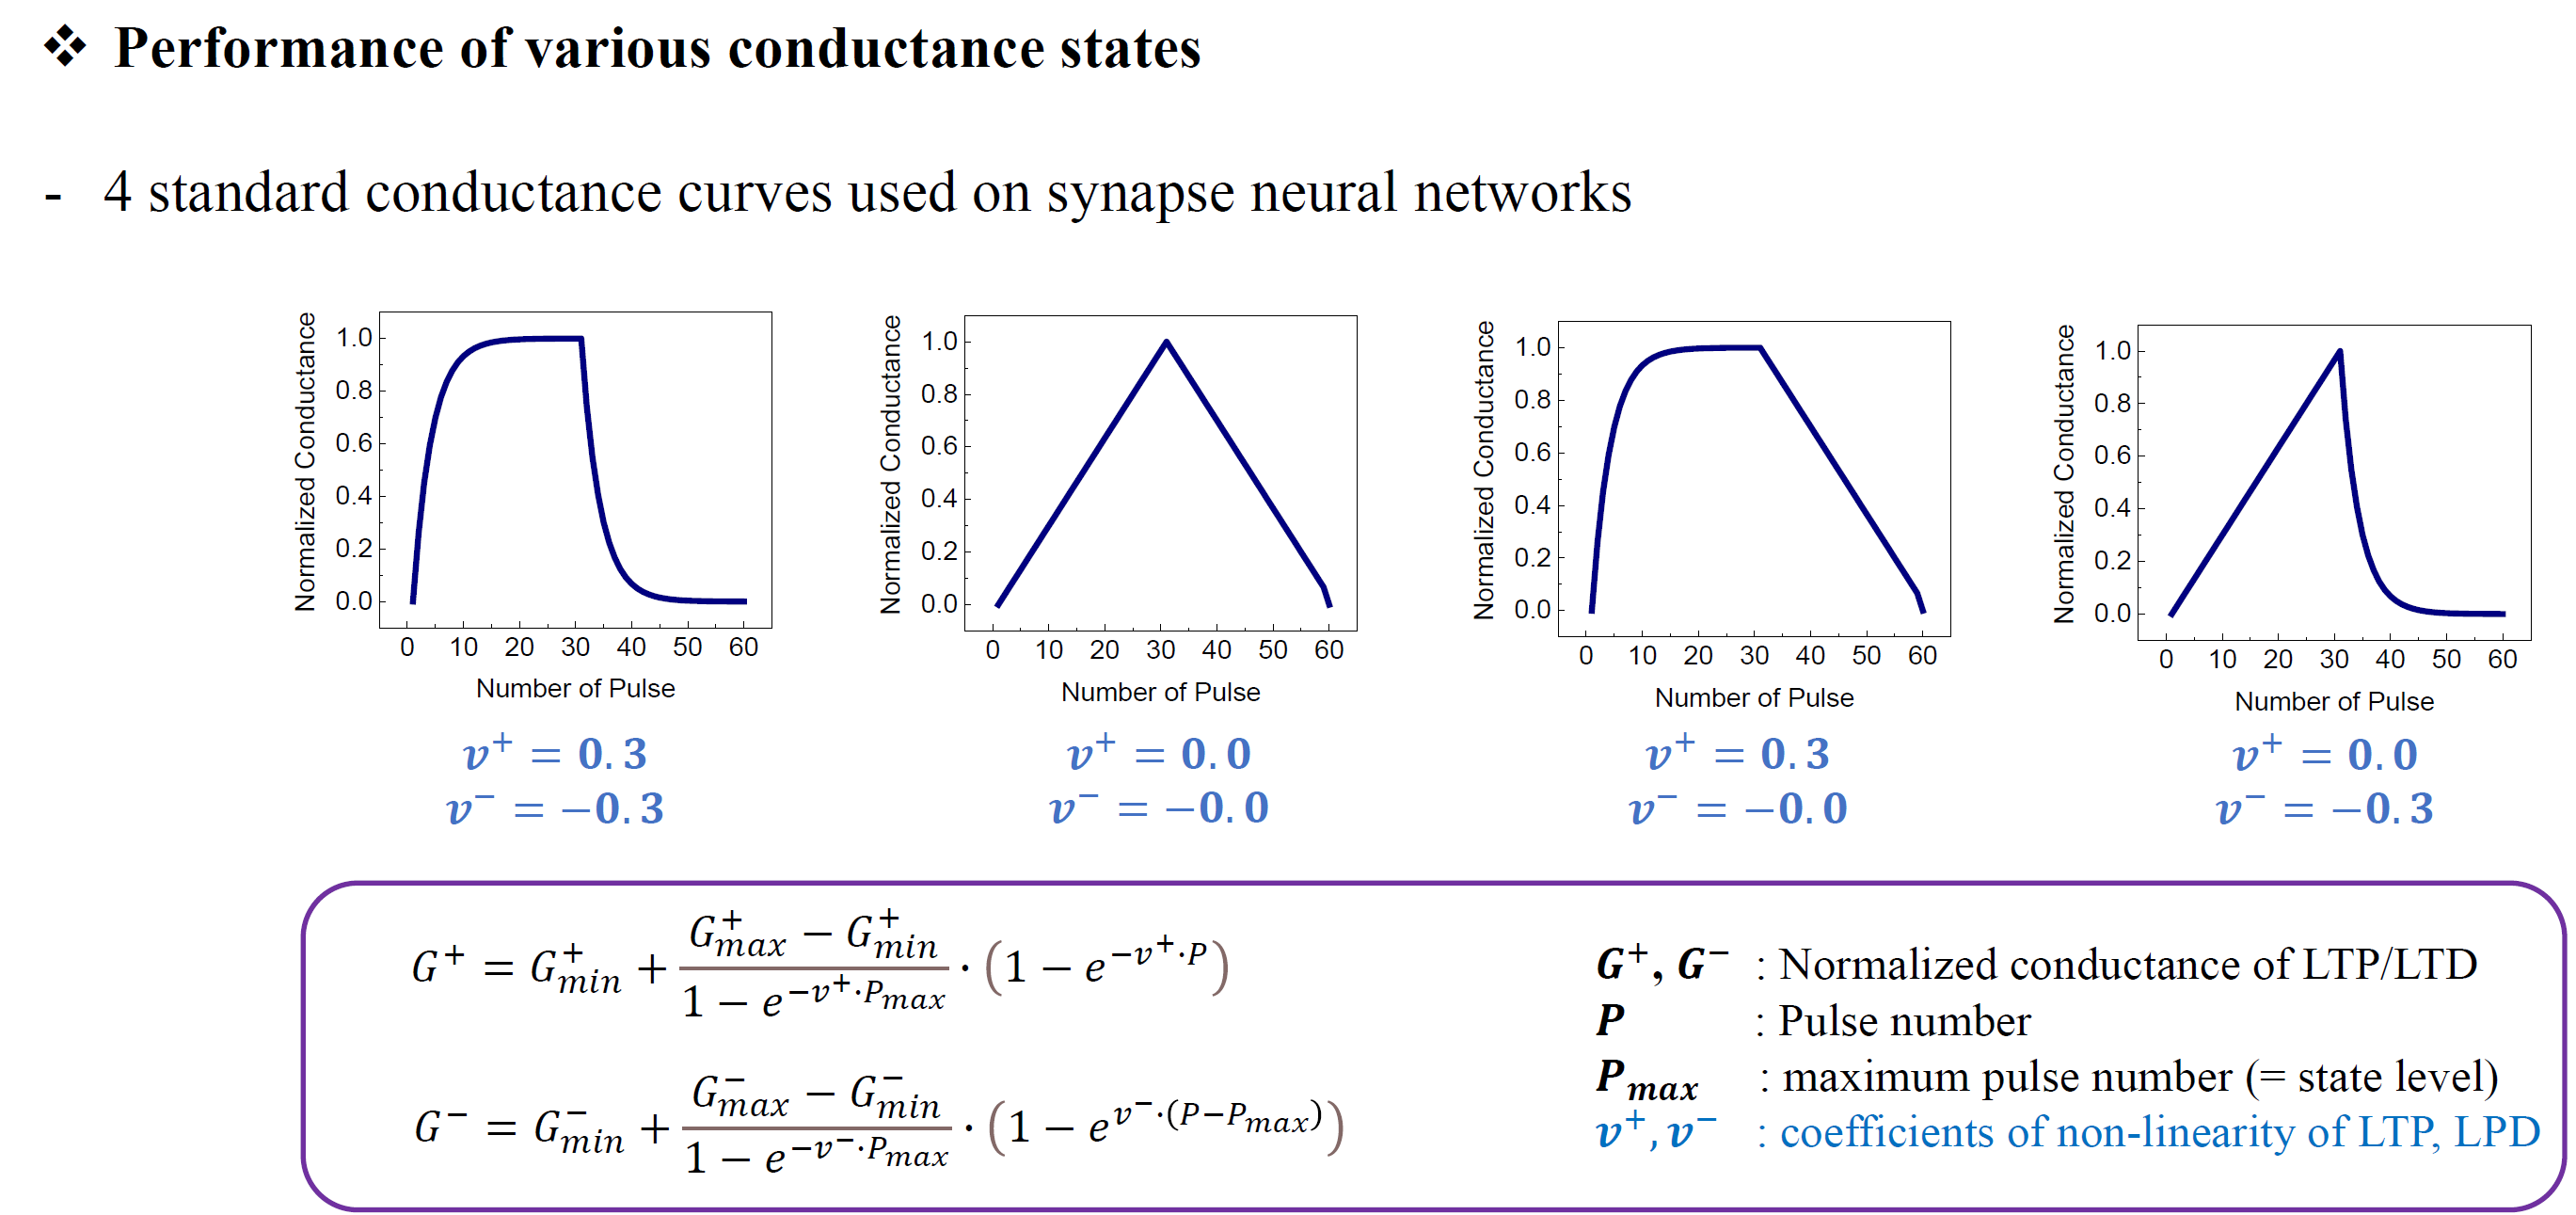

In [1]:
"""Based on the parameters of non-linear coefficient, create the fitting curve of conductance"""
"""실험데이터를 [0,1]로 normalize 하고 nonlinearity nu 만 추출해옴"""

def fitting_curve_generator(num_states, v_plus=None, v_minus=None, Mixed_curve=None, softmax_like=None):

    # non_potentiation_list = []
    # lin_potentiation_list = []
    # non_depression_list = []
    # lin_depression_list = []
    potentiation_list = []
    depression_list = []

    # non_v_plus = v_plus
    # non_v_minus = -v_plus
    # lin_v_plus = v_minus
    # lin_v_minus = -v_minus

    for i in range(num_states+1): # 0 ~ num_states=100 : 0은 state value로 count 하지 않음
        '''potentiation <-- Gmax=1,Gmin=0, linearity=v_plus > 0'''
        poten_state = (1-np.exp(-v_plus * i)) / (1-np.exp(-v_plus*num_states))
        potentiation_list.append(poten_state)

        '''depression <-- Gmax=0,Gmin=-1, linearity=v_minus > 0'''
        dep_state = (1-np.exp(v_minus * (i-num_states))) / (1-np.exp(v_minus*-num_states))
        depression_list.append(dep_state)

    # potentiation_list.append(1.0)
    # depression_list.append(0.0)

    return potentiation_list, depression_list



##**Generating conductance curves according to the non-linear coefficients**

[0.         0.00126758 0.00252883 0.00378379 0.0050325  0.00627497
 0.00751125 0.00874136 0.00996534 0.01118321 0.01239501 0.01360077
 0.01480051 0.01599427 0.01718207 0.01836395 0.01953994 0.02071005
 0.02187434 0.02303282 0.02418551 0.02533246 0.02647369 0.02760923
 0.0287391  0.02986334 0.03098197 0.03209503 0.03320253 0.0343045
 0.03540099 0.036492   0.03757757 0.03865773 0.03973249 0.0408019
 0.04186598 0.04292475 0.04397823 0.04502647 0.04606947 0.04710727
 0.0481399  0.04916738 0.05018973 0.05120698 0.05221916 0.05322629
 0.0542284  0.05522551 0.05621765 0.05720484 0.0581871  0.05916447
 0.06013696 0.0611046  0.06206742 0.06302543 0.06397867 0.06492715
 0.0658709  0.06680994 0.0677443  0.068674   0.06959906 0.07051951
 0.07143537 0.07234666 0.0732534  0.07415562 0.07505335 0.07594659
 0.07683538 0.07771974 0.07859969 0.07947524 0.08034644 0.08121328
 0.0820758  0.08293402 0.08378797 0.08463765 0.08548309 0.08632432
 0.08716135 0.0879942  0.08882291 0.08964748 0.09046793 0.091284

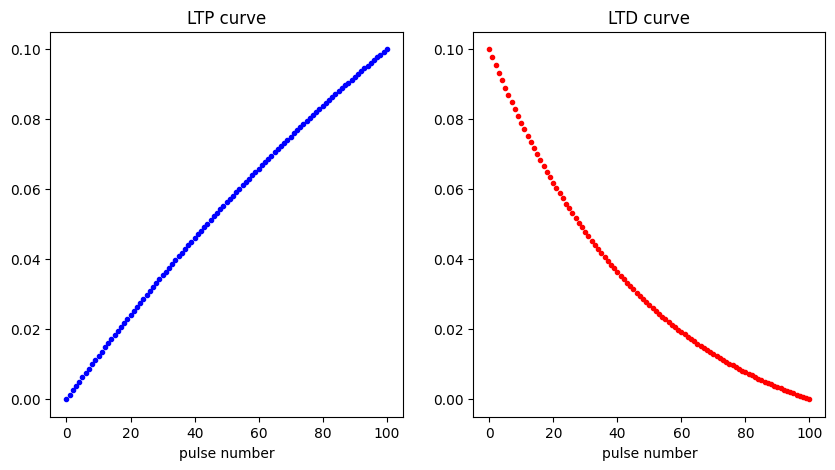

In [ ]:
fitting_w_plus, fitting_w_minus = fitting_curve_generator(num_states, v_plus, v_minus)

"""Normalize the weight to 0~0.1"""
w_plus = np.array(fitting_w_plus) * 0.1
w_minus = np.array(fitting_w_minus) * 0.1

'''w_plus=np.arary([0.0 0.11 0.24 ... ])
   w_minuss=np.arary([0.0 0.09 0.23 ... ])  txt 파일 등으로부터 읽어 올 수도 있음
'''

print(w_plus)
print(w_minus)

"""plot LTP, LTD curves"""
plt.figure(figsize=(10, 5)) # 그림을 새로 그리겠다
plt.subplot(1,2,1) # 1 by 2 로 배열할 것이고, 그 중에 첫번째 그림
plt.plot(w_plus, 'b.') # x=0~101 (0부터 w_plus 데이터 개수만큼), y=w_plus 값, blue dot 으로 표현
plt.title('LTP curve')
plt.xlabel('pulse number')
plt.subplot(1,2,2)
plt.plot(w_minus, 'r.')
plt.title('LTD curve')
plt.xlabel('pulse number')
plt.show()

In [ ]:

""" Randomly (Gaussian) generating the first index of conductance states """
# def int_idx_generator(num_weight, std):
def int_idx_generator(num_states, init_std):

    # num_w = num_weight+1
    # std_scaling = np.sqrt(num_weight / 50)

    # if num_w % 2 != 0:
    #     x = np.arange(np.round(-(num_w + 1) / 2), (num_w + 1) / 2)
    #     shift = (num_w + 1) / 2


    # else:
    #     x = np.arange(np.round(-num_w / 2), num_w / 2 + 1)
    #     shift = num_w / 2

    # xU, xL = x + 0.5, x - 0.5
    # prob = ss.norm.cdf(xU, scale=std * std_scaling) - ss.norm.cdf(xL, scale=std * std_scaling)
    # prob = prob / prob.sum()

    # fc1_wp_idx = np.random.choice(x, size=784 * 200, p=prob) + shift
    # fc1_wm_idx = np.random.choice(x, size=784 * 200, p=prob) + shift
    # fc2_wp_idx = np.random.choice(x, size=200 * 10, p=prob) + shift
    # fc2_wm_idx = np.random.choice(x, size=200 * 10, p=prob) + shift

    # fc1_wp_idx = np.random.choice(num_states+1, size=784 * 200)
    # fc1_wm_idx = np.random.choice(num_states+1, size=784 * 200)
    # fc2_wp_idx = np.random.choice(num_states+1, size=200 * 10)
    # fc2_wm_idx = np.random.choice(num_states+1, size=200 * 10)

    mu=0
    std=num_states*init_std
    prob=[]
    for i in range(num_states+1):
        prob.append(ss.norm.cdf((i+1-mu)/std)-ss.norm.cdf((i-mu)/std))

    # fc1_wp_idx = random.choices(list(range(num_states+1)), prob, k=784*200)
    # fc1_wm_idx = random.choices(list(range(num_states+1)), prob, k=784*200)
    # fc2_wp_idx = random.choices(list(range(num_states+1)), prob, k=200*10)
    # fc2_wm_idx = random.choices(list(range(num_states+1)), prob, k=200*10)

    # fc1_wp_idx = np.array(random.choices(list(range(num_states+1)), prob, k=784*200))
    # fc1_wm_idx = np.array(random.choices(list(range(num_states+1)), prob[::-1], k=784*200))
    # fc2_wp_idx = np.array(random.choices(list(range(num_states+1)), prob, k=200*10))
    # fc2_wm_idx = np.array(random.choices(list(range(num_states+1)), prob[::-1], k=200*10))

    fc1_wp_idx = np.array(random.choices(list(range(num_states+1)), prob, k=784*200))
    fc1_wm_idx = np.array(random.choices(list(range(num_states+1)), prob, k=784*200))
    fc2_wp_idx = np.array(random.choices(list(range(num_states+1)), prob, k=200*10))
    fc2_wm_idx = np.array(random.choices(list(range(num_states+1)), prob, k=200*10))


    return fc1_wp_idx, fc1_wm_idx, fc2_wp_idx, fc2_wm_idx



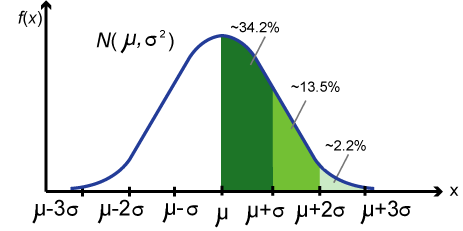

0.5


<function matplotlib.pyplot.show(close=None, block=None)>

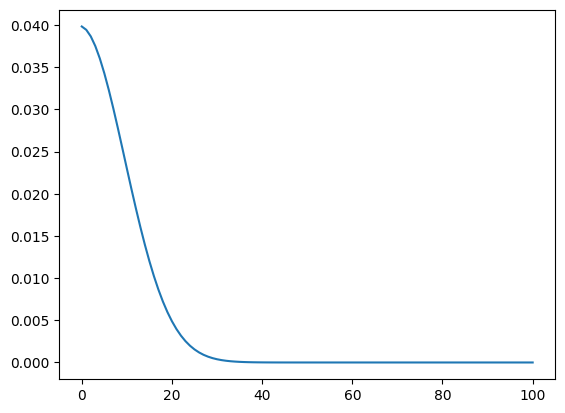

In [ ]:
mu=0
std=num_states*0.1
prob=[]
for i in range(num_states+1):
    prob.append(ss.norm.cdf((i+1-mu)/std)-ss.norm.cdf((i-mu)/std))
print(np.sum(prob))
plt.plot(prob)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

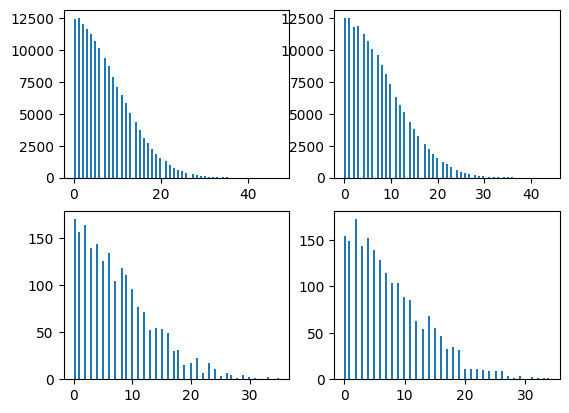

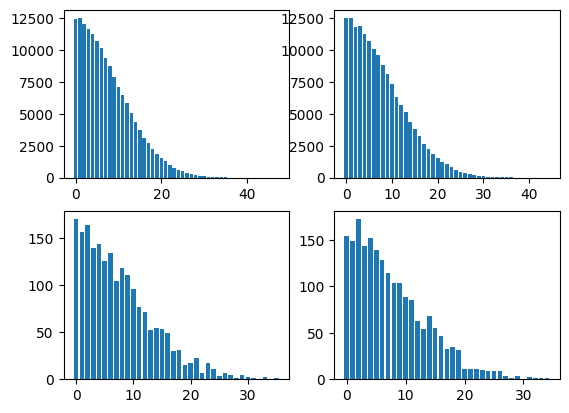

In [ ]:
weight_idx = int_idx_generator(num_states, init_std)

plt.figure() # for histogram
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.hist(weight_idx[i], bins=num_states+1)
plt.show

plt.figure() # for barplot
for i in range(4):
  # b=[]
  # for j in range(num_states+1):
  #     b[j]=weight_idx[i].count(j)

  plt.subplot(2,2,i+1)
  # plt.bar(list(range(num_states+1)),b)
  xx, yy = np.array(np.unique(weight_idx[i], return_counts=True))
  plt.bar(xx,yy)
plt.show

In [ ]:

""" According to the index, calculate the weights by calculation between LTP & LTD of two devices """
def new_weight_generator(w_plus, w_minus, wp_idx, wm_idx, scale=None):
    '''
       w_plus (소자가 갖을 수 있는 값들): 크기 = 0~100, 값 = 0.0 ~ 0.1
       wp_idx (웨이트가 소자 값들 중 몇 번째 값에 해당되는지 표시): 크기 784x200 (fc1), 200x10 (fc2), 값 = 0~100
       new_weight_plus (웨이트에 i번째 소자값을 넣는다): 크기 784x200 (fc1), 200x10 (fc2), 값 = 0~100
    '''

    new_weight_plus = torch.zeros(wp_idx.shape)
    new_weight_minus = torch.zeros(wm_idx.shape)

    '''According to the shape number, assign different conductance curve'''
    for i in range(len(w_plus)):
        new_weight_plus[wp_idx==i] = w_plus[i] # 행렬[조건]=값 --> 웨이트행렬[i번째 소자값을 넣어야하는 경우]=i번째 소자값
        new_weight_minus[wm_idx==i] = w_minus[i]

    '''Add normal noise to synaptic weights'''
    # noise = np.random.normal(0, 0.3, wp_idx.shape)
    noise = 0

    new_weight = new_weight_plus + new_weight_minus - 0.1

    if scale:
        weight_w_noise = (new_weight + new_weight*0.1*noise) * scale
    else:
        weight_w_noise = new_weight + new_weight*0.1*noise

    return weight_w_noise.float()



<function matplotlib.pyplot.show(close=None, block=None)>

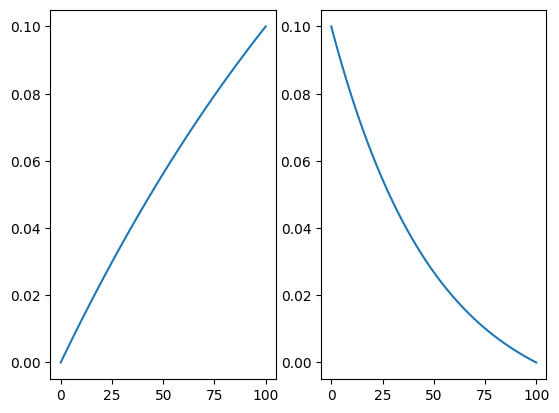

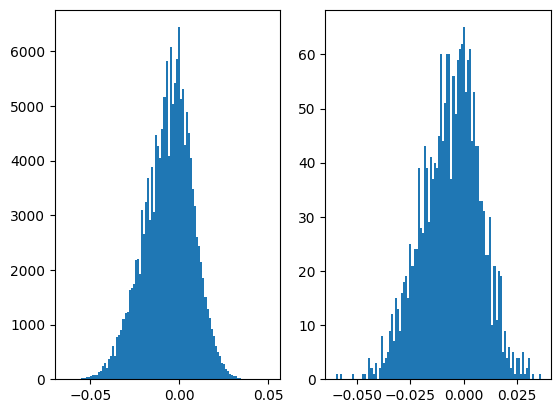

In [ ]:
w_plus, w_minus = fitting_curve_generator(num_states, v_plus, v_minus)
w_plus = np.array(w_plus) * 0.1
w_minus = np.array(w_minus) * 0.1

plt.figure()
plt.subplot(1,2,1)
plt.plot(w_plus)
plt.subplot(1,2,2)
plt.plot(w_minus)
plt.show


w_fc1_p_idx, w_fc1_m_idx, w_fc2_p_idx, w_fc2_m_idx = int_idx_generator(num_states, init_std)
w_fc1 = new_weight_generator(w_plus, w_minus, w_fc1_p_idx, w_fc1_m_idx, scale=None)
w_fc2 = new_weight_generator(w_plus, w_minus, w_fc2_p_idx, w_fc2_m_idx, scale=None)

plt.figure()
plt.subplot(1,2,1)
plt.hist(w_fc1, bins=100)
plt.subplot(1,2,2)
plt.hist(w_fc2, bins=100)
plt.show


""" According to the sign of gradient, update index of LTP & LTD states """
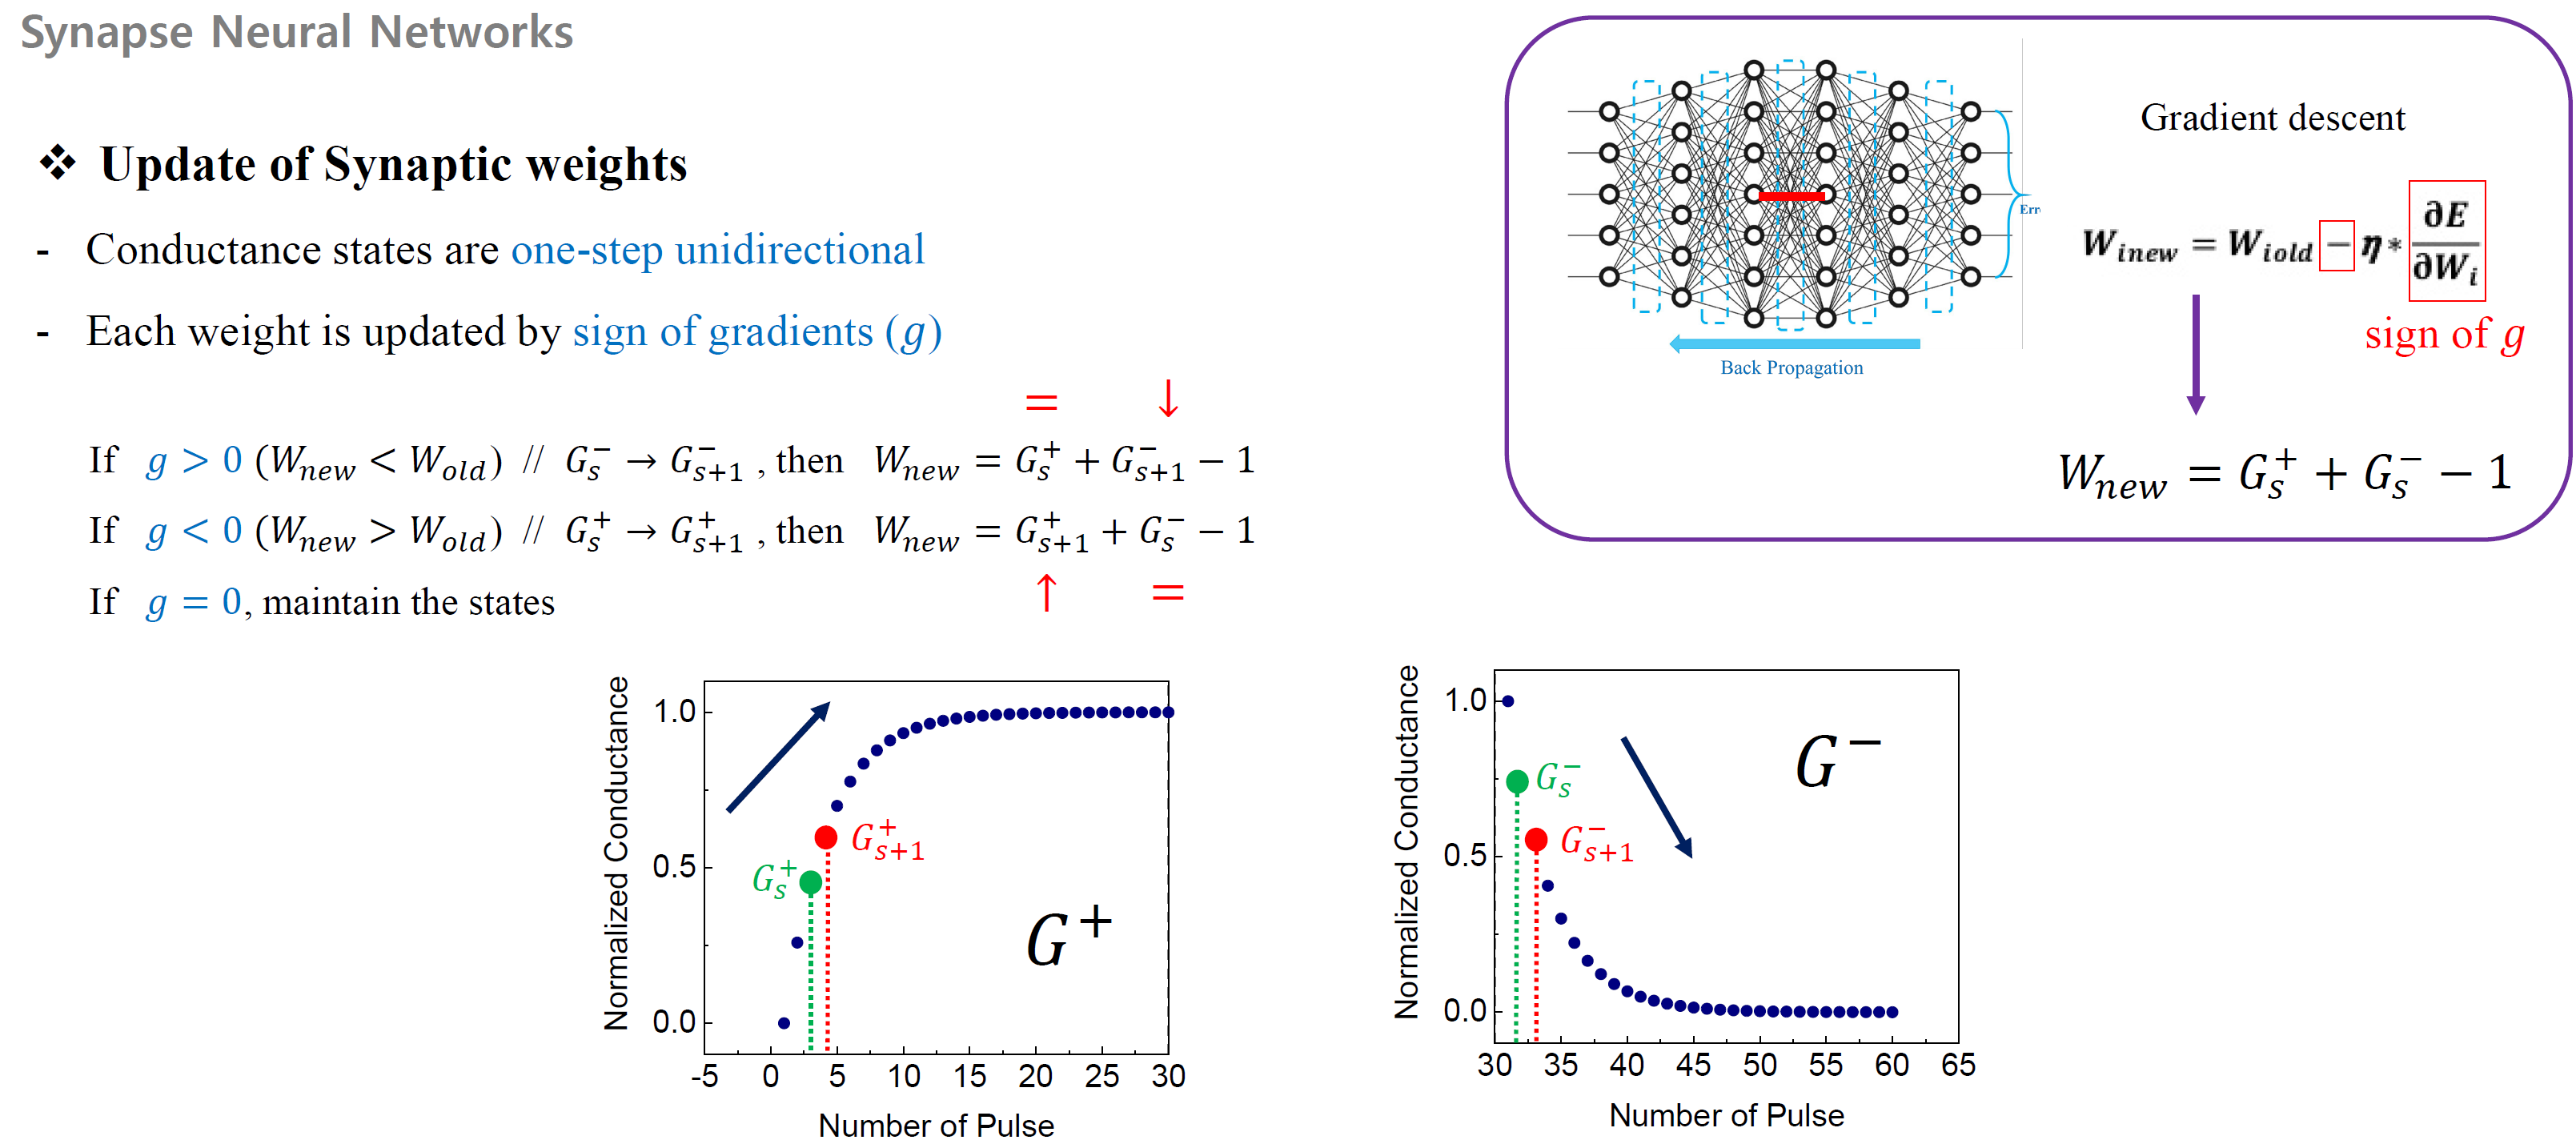



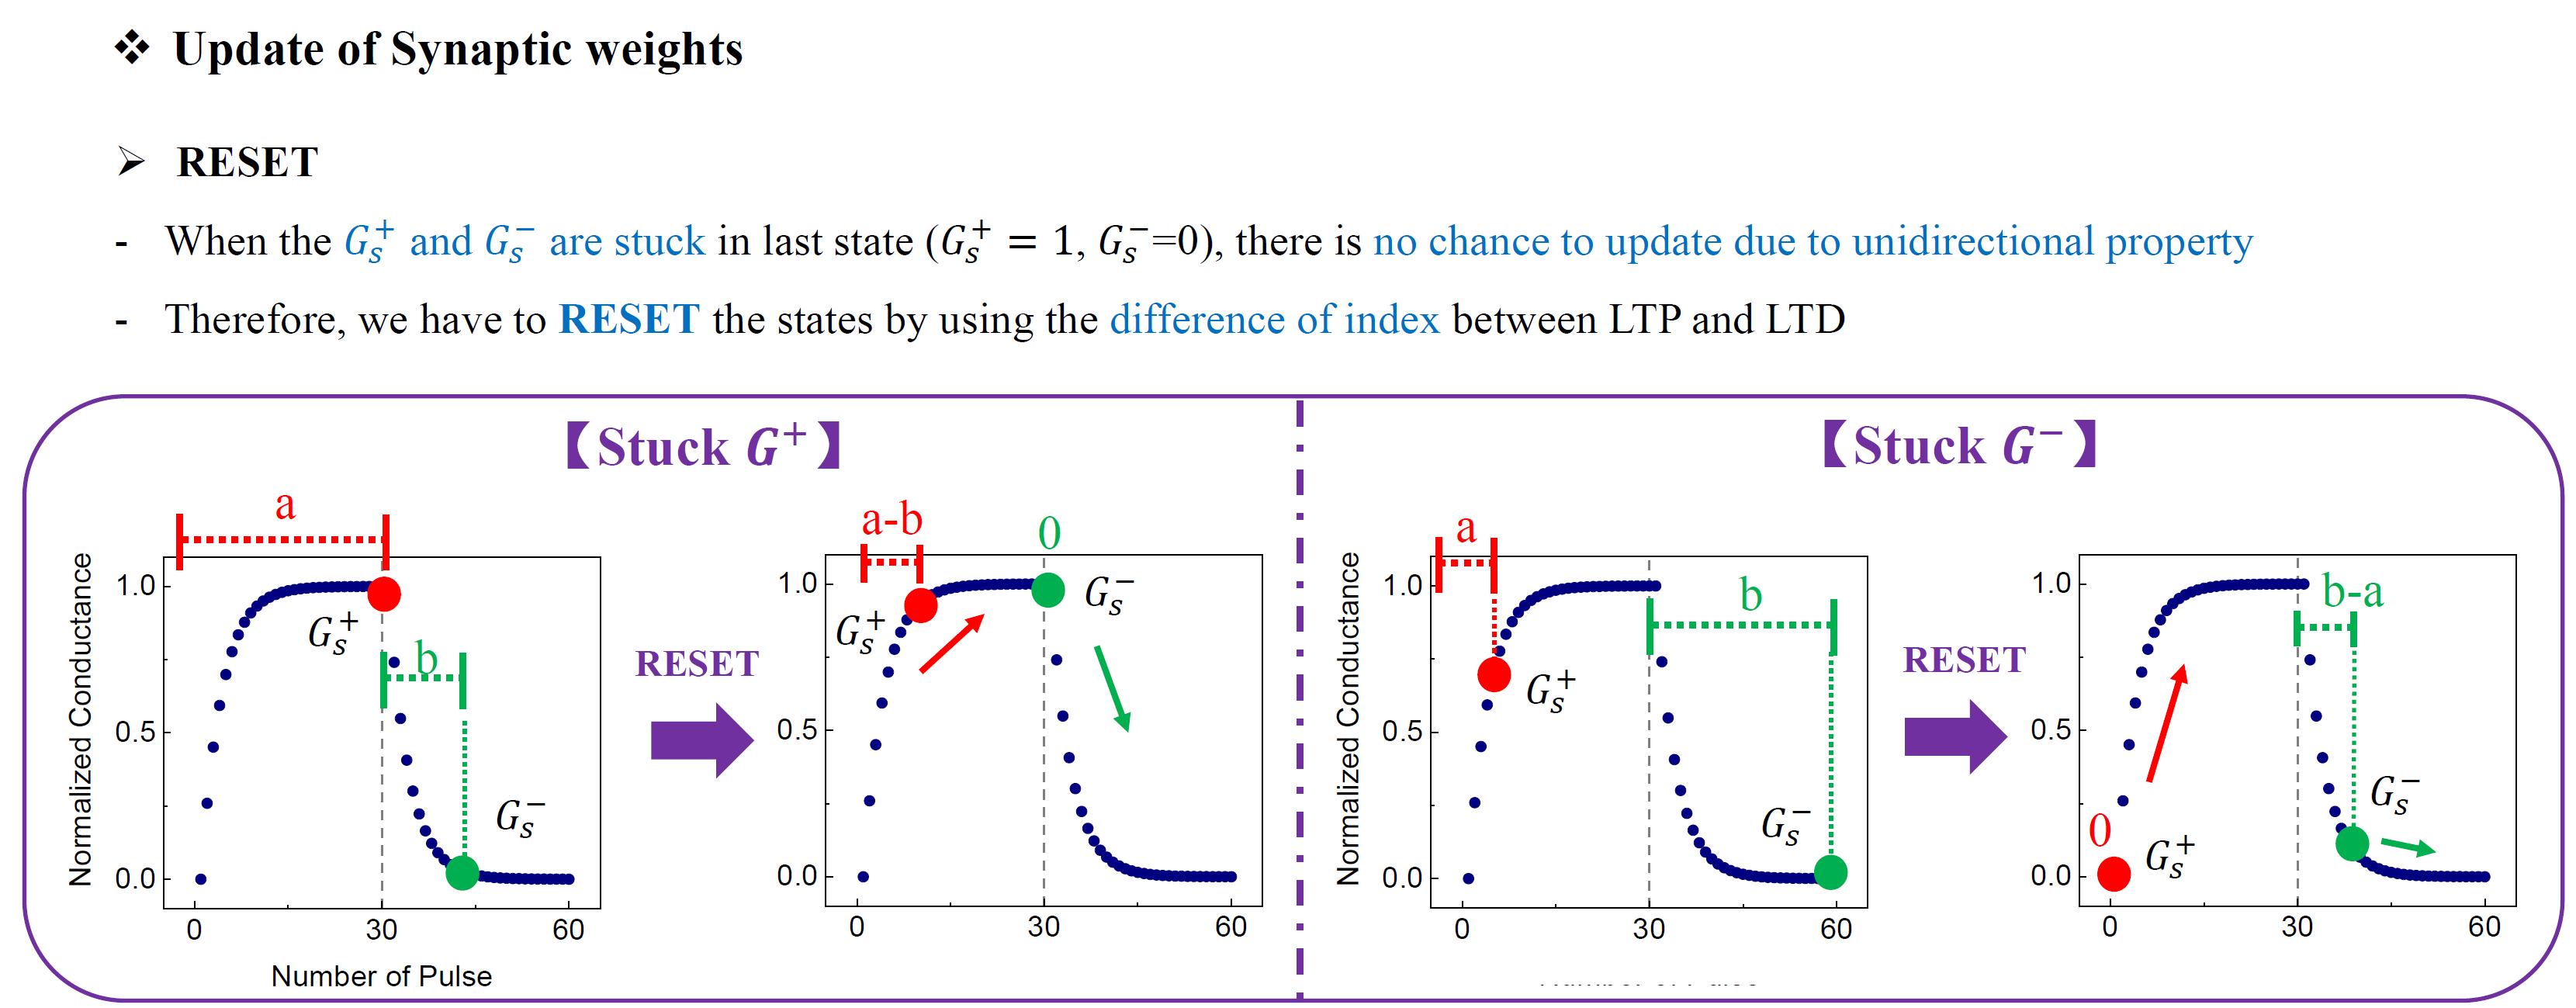

In [1]:

""" According to the sign of gradient, update index of LTP & LTD states """
def idx_update(layer_sign, wp_idx, wm_idx, num_w, stoch_update):
    '''
       layer_sign: 크기 = 784x200 (fc1), 200x10 (fc2), 값 = 1 (>0), 0 (<=0)
       wp_idx (웨이트가 소자 값들 중 몇 번째 값에 해당되는지 표시): 크기 784x200 (fc1), 200x10 (fc2), 값 = 0~100
       new wp_idx : layer_sign 에 따라 wp_idx의 인덱스값을 하나씩 증가시킴. Stuck 된 경우 평행이동.
    '''
    layer_sign = layer_sign.flatten()
    pos_sign = np.array(layer_sign.to('cpu'))
    neg_sign = np.array(layer_sign.to('cpu'))

    pos_sign[pos_sign < 0] = 0 # layer_sign 중에서 음수만 0 인 행렬, 양수용 mask
    neg_sign[neg_sign > 0] = 0 # layer_sign 중에서 양수만 0 인 행렬, 음수용 mask

    rand_array = np.random.rand(*pos_sign.shape)
    mask = rand_array < stoch_update # 0.9 (90%) 값만 그대로 두는 stochastic mask
    pos_sign = pos_sign * mask

    rand_array = np.random.rand(*neg_sign.shape)
    mask = rand_array < stoch_update # 0.9 (90%) 값만 그대로 두는 stochastic mask
    neg_sign = neg_sign * mask

    # if stoch_update:
    #     for_pos = np.random.randint(low=0, high=stoch_update, size=pos_sign.shape)
    #     for_neg = np.random.randint(low=0, high=stoch_update, size=pos_sign.shape)

    #     for_pos[pos_sign==0] = 0
    #     for_pos[for_pos<=stoch_update-2] = 0
    #     for_pos[for_pos>stoch_update-2] = -1

    #     for_neg[neg_sign==0] = 0
    #     for_neg[for_neg<=stoch_update-2] = 0
    #     for_neg[for_neg>stoch_update-2] = 1

    #     pos_sign += for_pos
    #     neg_sign += for_neg

    wm_idx = np.clip(wm_idx + pos_sign, 0, num_w)
    # minus weight에 positive sign 더함: -sign으로 업데이트 -> pos_sign 해당 웨이트 감소 -> minus weight 인덱스 증가 (=positive sign 더하기)
    wp_idx = np.clip(wp_idx + np.abs(neg_sign), 0, num_w)
    # positive weight에 negative sign 의 절대값 더함: -sign으로 업데이트 -> neg_sign 해당 웨이트 감소 -> plus weight 인덱스 증가 (=abs(negative sign) 더하기)

    for i in range(len(layer_sign)):
        if (wp_idx[i] == num_w and wm_idx[i] != 0) or (wm_idx[i] == num_w and wp_idx[i] != 0): # [G+=100이고 G-=0이 아니면] 또는 [G-=100이고 G+=0이 아니면]
            differ = min(wp_idx[i], wm_idx[i]) # 둘 중에 작은 인덱스값만큼 원래 인덱스 값에서 빼준다
            wp_idx[i] -= int(differ)
            wm_idx[i] -= int(differ)

    return wp_idx, wm_idx

""" According to the index, calculate the weights by calculation between LTP & LTD of two devices """
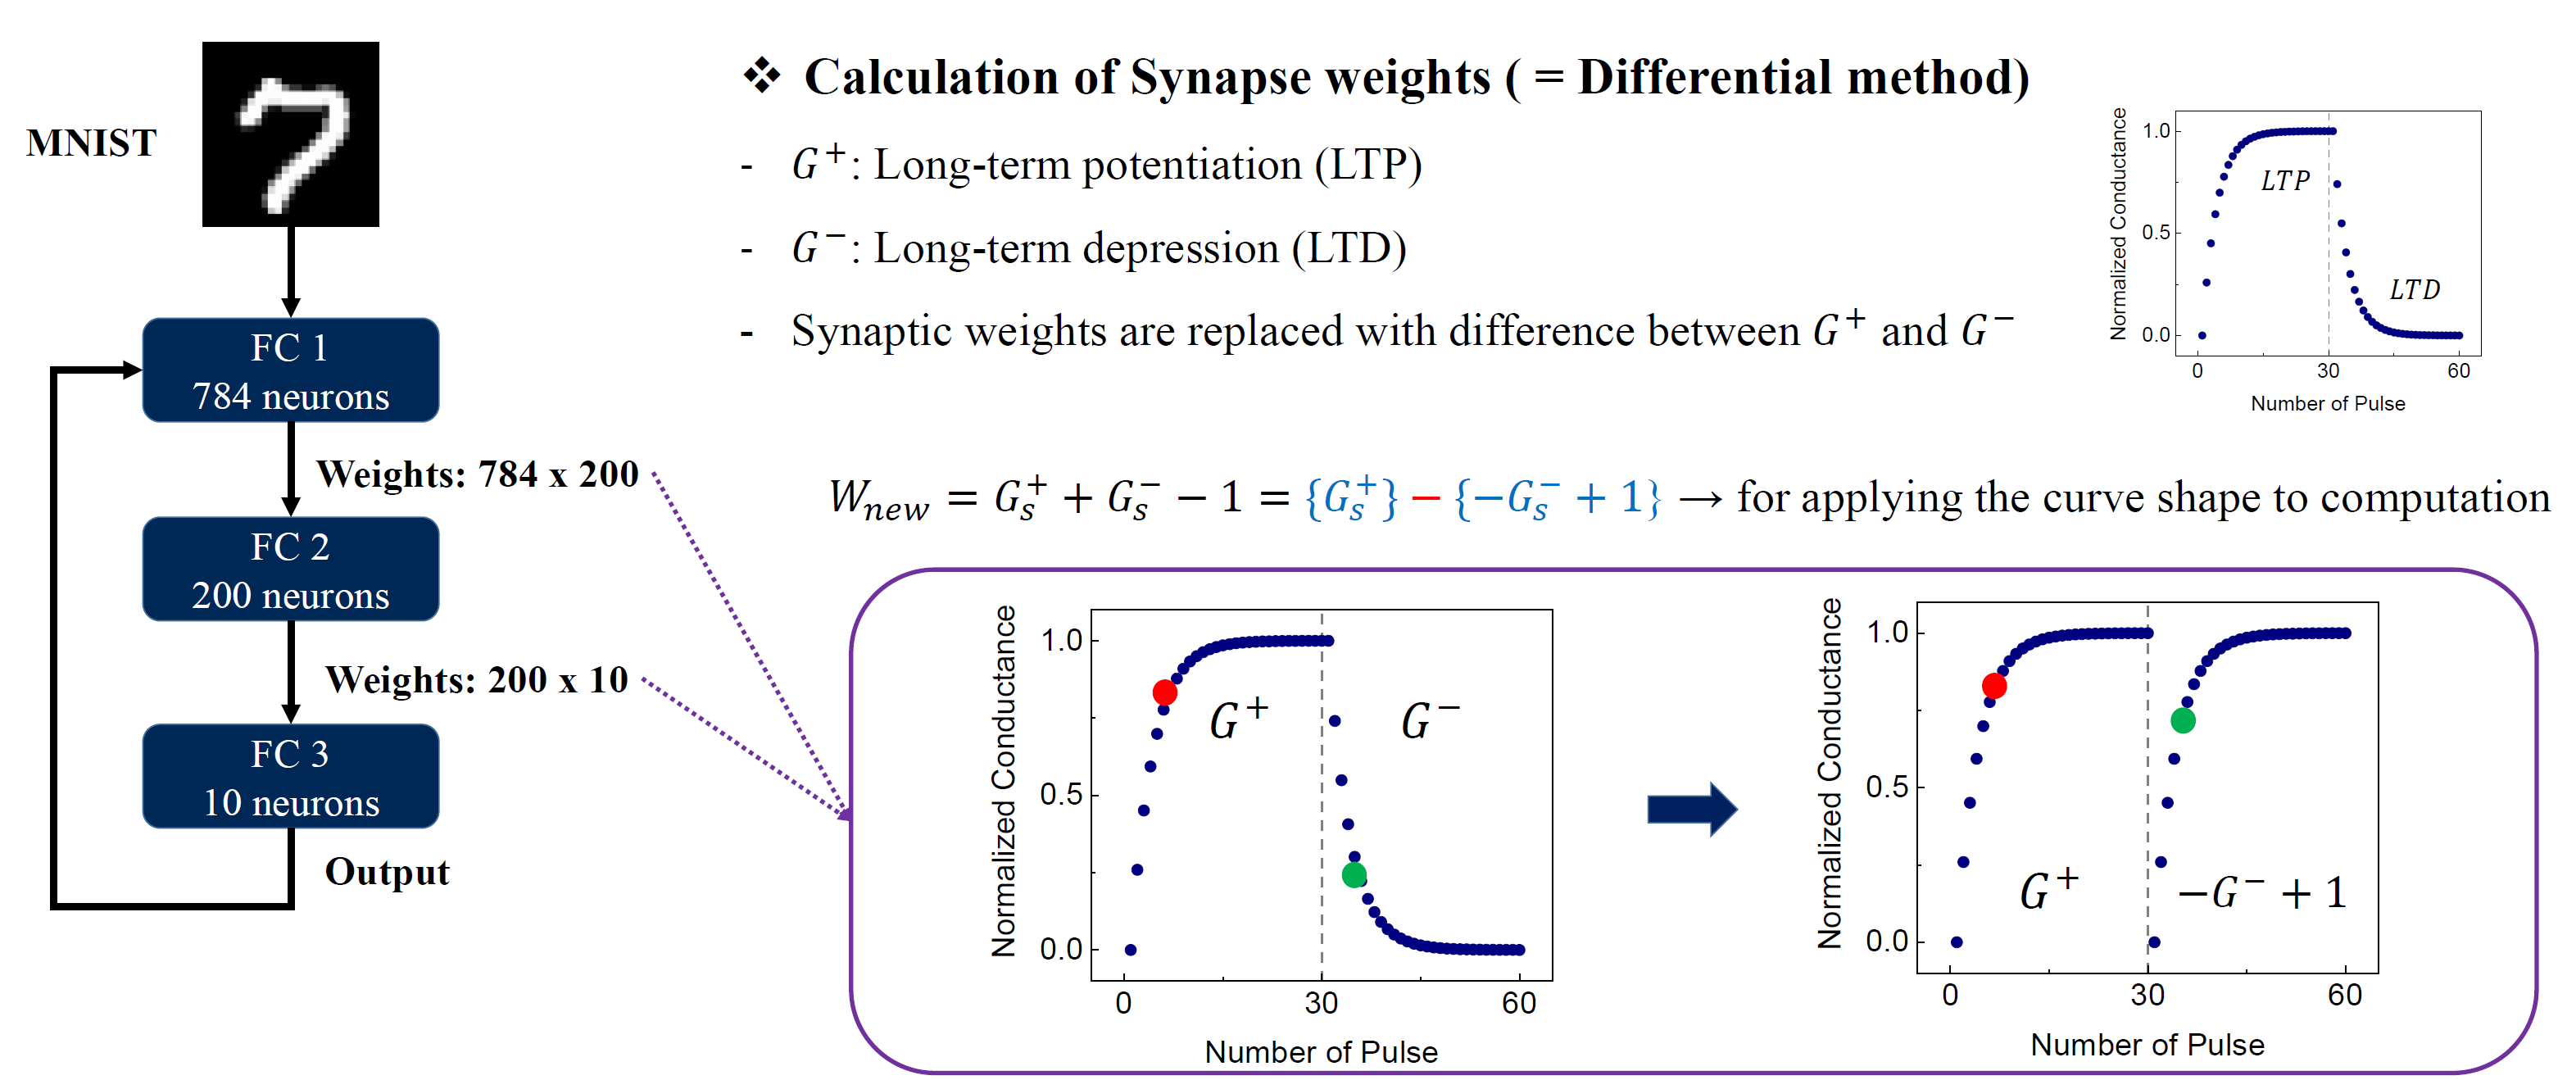

##**Deap learning model definition**

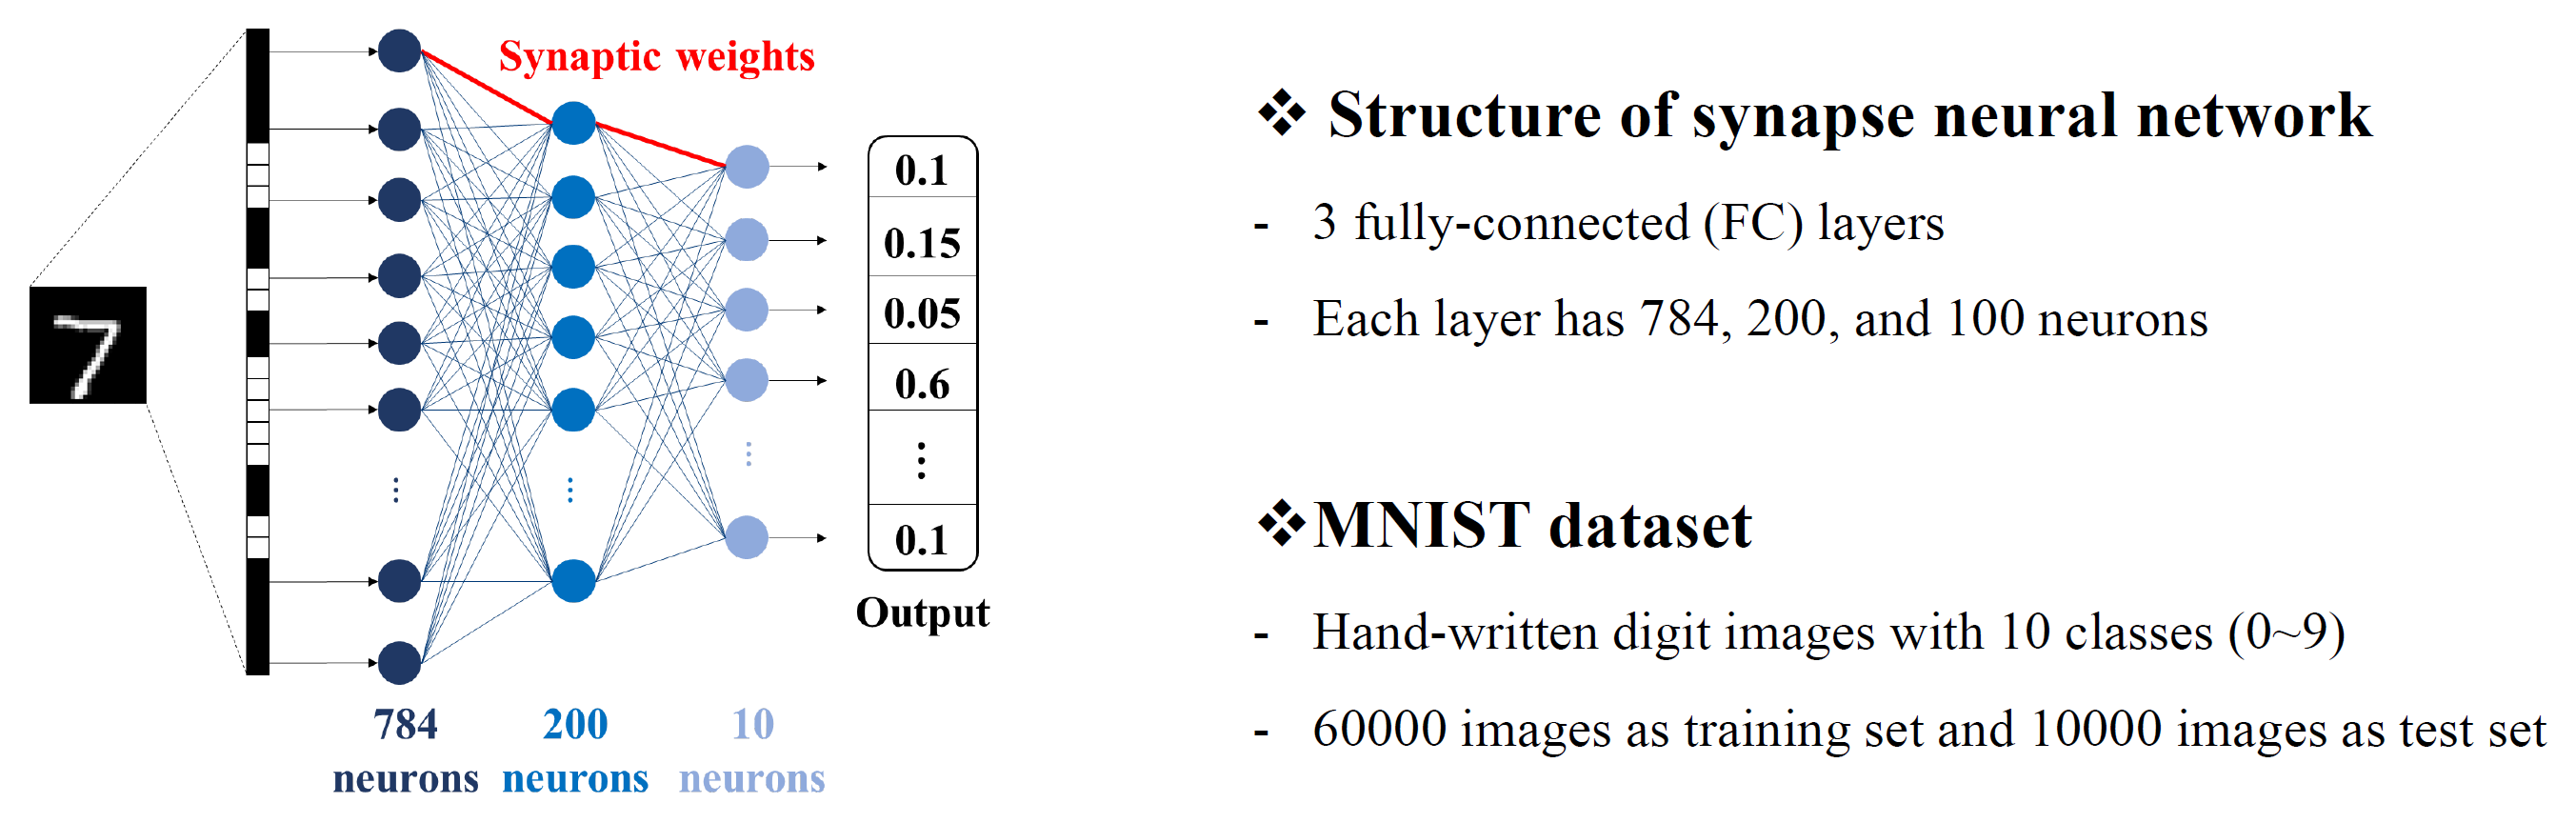

In [ ]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 200, bias=None)
        self.fc2 = nn.Linear(200, 10, bias=None)
        self.act = nn.ReLU()
    def forward(self, x):
        out = x.reshape(x.size(0), -1)
        out = self.fc1(out)
        out = self.act(out)
        out = self.fc2(out)
        return out

device_model = CIFAR10_CNN().to(device)

##**Based on index of conductance states, calculate the weights of each neuron**
##weights = LTP + LTD - 0.1

In [ ]:
# num_w = num_states-1

'''Generate integer index according to the number of device weights'''
fc1_wp_idx, fc1_wm_idx, fc2_wp_idx, fc2_wm_idx = int_idx_generator(num_states, init_std)

'''According to the integer index, generate weights of device model'''
"""FC1 = input ~ hidden layer weights / FC2 = hidden ~ output layer weights"""
fc1_init_weight = new_weight_generator(w_plus, w_minus, fc1_wp_idx, fc1_wm_idx)
fc2_init_weight = new_weight_generator(w_plus, w_minus, fc2_wp_idx, fc2_wm_idx)

fc1_init_weight = torch.reshape(fc1_init_weight, (200, -1)).to(device)
fc2_init_weight = torch.reshape(fc2_init_weight, (10, -1)).to(device)

print(fc2_wp_idx, fc2_wm_idx)
print(fc2_init_weight)

[12 14 11 ...  2  1  2] [10  2 14 ... 10  7  6]
tensor([[-6.1636e-03,  1.2647e-02, -1.4643e-02,  ..., -2.0059e-03,
         -8.0385e-03,  7.5113e-03],
        [-1.9055e-02, -2.3949e-02, -1.3453e-02,  ..., -1.7025e-03,
          5.2212e-03,  5.0325e-03],
        [ 1.6588e-03,  7.6753e-03,  7.5113e-03,  ...,  8.2232e-05,
          5.2291e-04, -7.6242e-03],
        ...,
        [-8.3585e-03, -4.7308e-03,  1.9651e-02,  ...,  6.2750e-03,
          3.2550e-03, -2.0568e-02],
        [-2.3700e-02,  1.7182e-02, -9.2941e-03,  ..., -1.1656e-02,
         -1.9276e-02, -5.9732e-03],
        [-9.2941e-03, -1.1656e-02,  8.7414e-03,  ..., -1.8435e-02,
         -1.3841e-02, -1.0549e-02]])


##**Training the model defined above**
In every epoch, test the trained model with test dataset

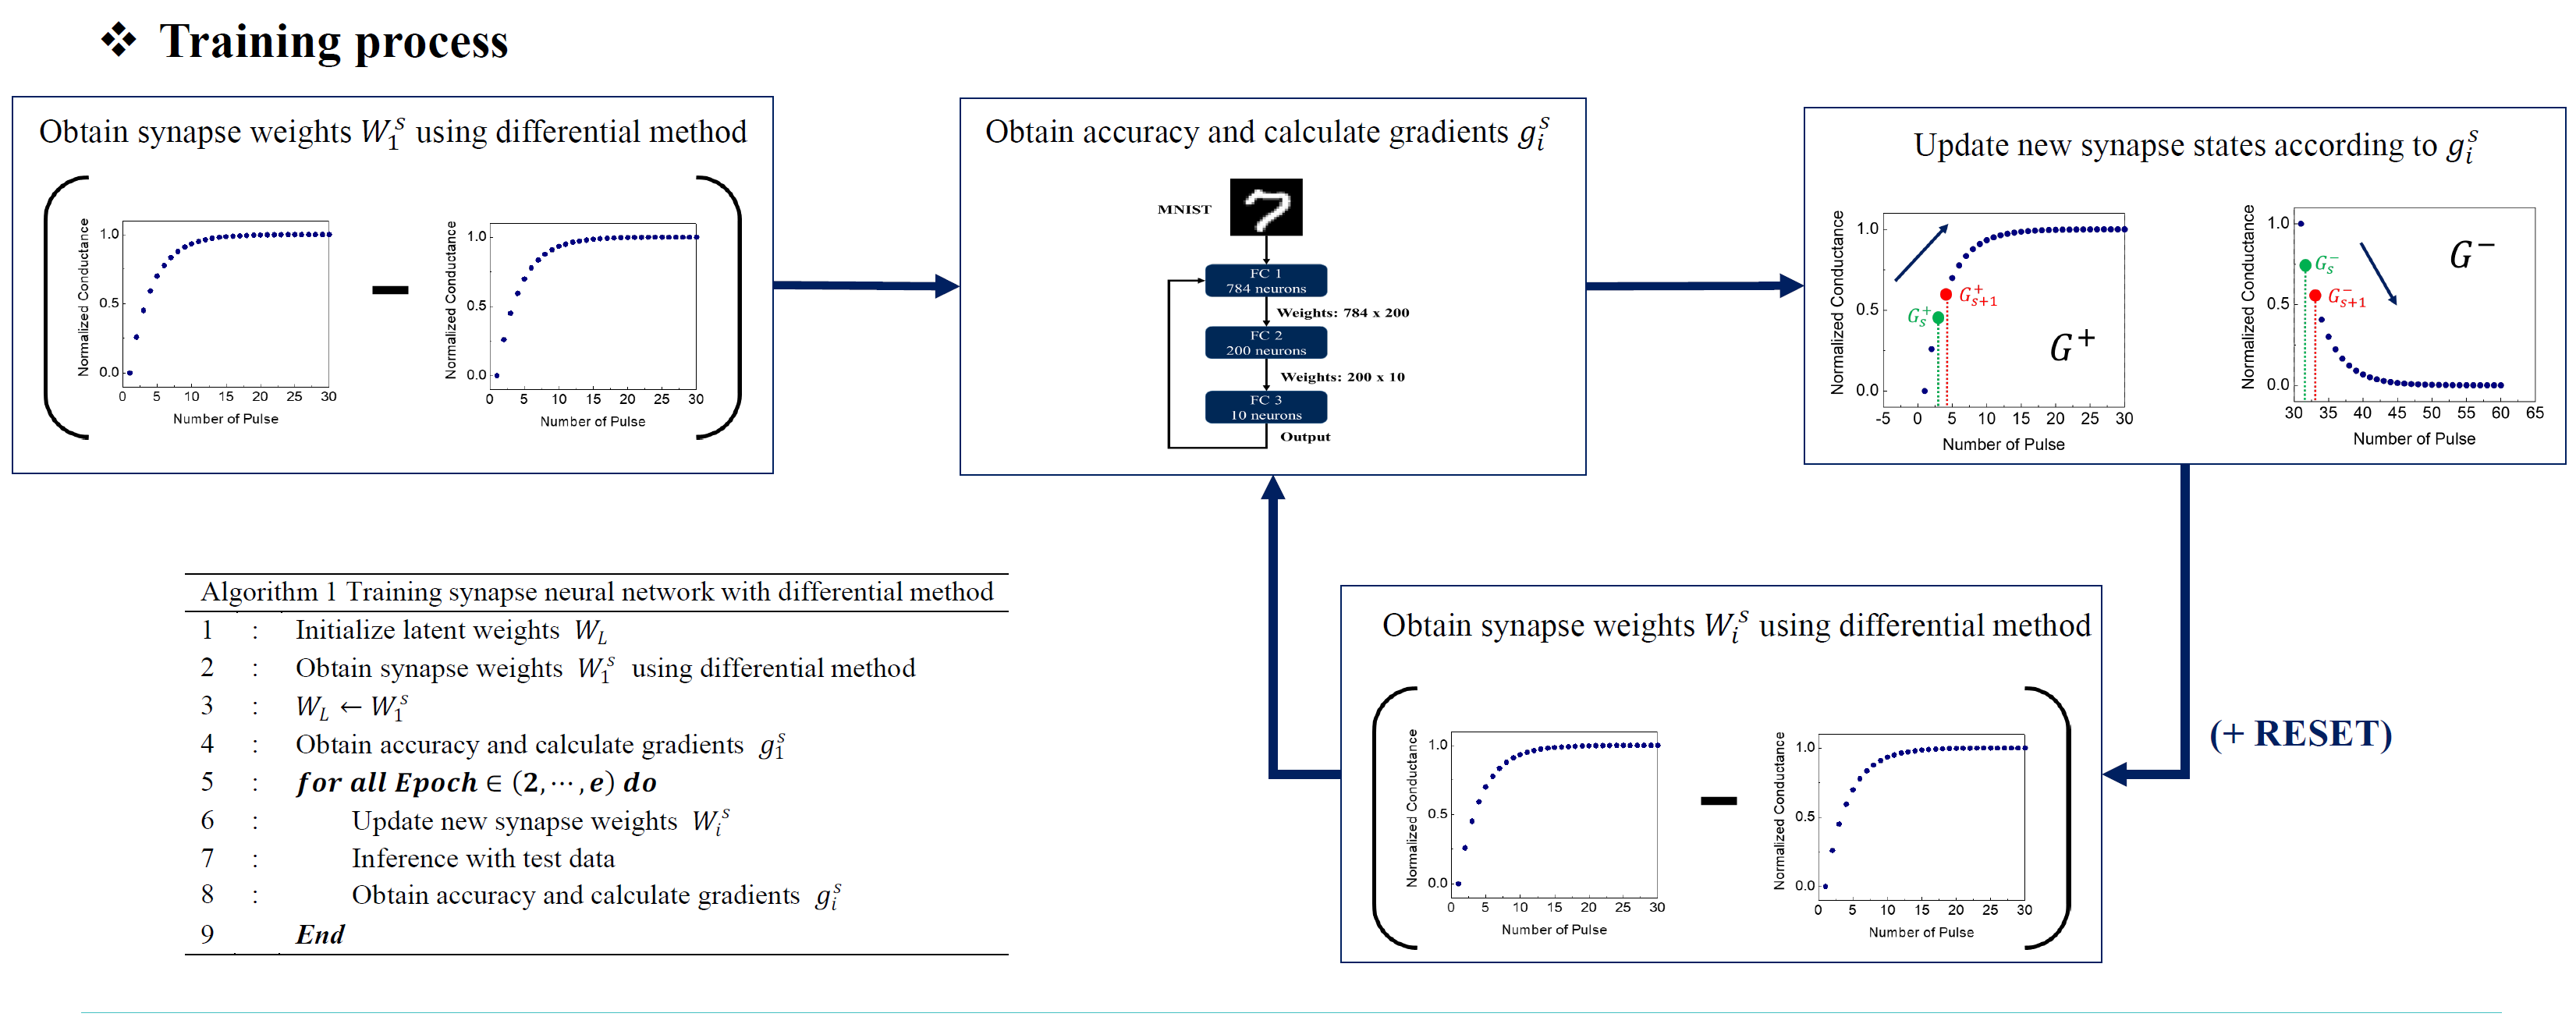

0 epoch:  loss = 0.908  /  TEST accuracy = 67.750  /  MAX accuracy= 67.750
1 epoch:  loss = 0.789  /  TEST accuracy = 70.860  /  MAX accuracy= 70.860
2 epoch:  loss = 0.646  /  TEST accuracy = 74.870  /  MAX accuracy= 74.870
3 epoch:  loss = 0.643  /  TEST accuracy = 74.870  /  MAX accuracy= 74.870
4 epoch:  loss = 0.582  /  TEST accuracy = 77.530  /  MAX accuracy= 77.530
5 epoch:  loss = 0.512  /  TEST accuracy = 79.220  /  MAX accuracy= 79.220
6 epoch:  loss = 0.547  /  TEST accuracy = 78.530  /  MAX accuracy= 79.220
7 epoch:  loss = 0.524  /  TEST accuracy = 79.970  /  MAX accuracy= 79.970
8 epoch:  loss = 0.455  /  TEST accuracy = 80.890  /  MAX accuracy= 80.890
9 epoch:  loss = 0.485  /  TEST accuracy = 80.900  /  MAX accuracy= 80.900
10 epoch:  loss = 0.471  /  TEST accuracy = 81.460  /  MAX accuracy= 81.460
11 epoch:  loss = 0.435  /  TEST accuracy = 82.000  /  MAX accuracy= 82.000
12 epoch:  loss = 0.414  /  TEST accuracy = 82.340  /  MAX accuracy= 82.340
13 epoch:  loss = 0.41

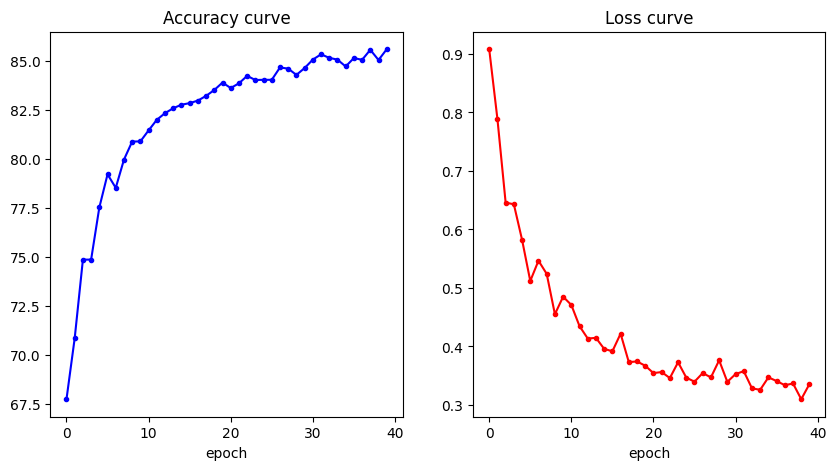

In [ ]:
acc_list = []
loss_list = []
for j in range(epoch):
    i = 0
    device_model.train()

    fc1_weight_list = []
    fc2_weight_list = []

    fc1_grad_list = []
    fc2_grad_list = []

    '''train---------------------------------------------------------------'''
    for x, label_int in train_dl:
        x = x.to(device)
        label_int = label_int.to(device)


        ''' 초기화 소자 weight를 model에 넣기'''
        if j == 0 and i == 0:
            for name, p in device_model.named_parameters():
                if name == 'fc1.weight':
                    p.data = fc1_init_weight.clone().detach()
                    # pass
                if name == 'fc2.weight':
                    p.data = fc2_init_weight.clone().detach()
                    # pass
                else:
                    pass
        else:
            pass

        '''inference'''
        y = device_model(x)

        '''Loss & gradient'''
        loss = F.cross_entropy(y, label_int)
        loss.backward()

        '''gradient sign을 얻기'''
        for name, p in device_model.named_parameters():
            if name == 'fc1.weight':
                p.grad[torch.abs(p.grad) < grad_threshold_fc1] = 0
                fc1_sign = torch.sign(p.grad)  # 784 * 200

            if name == 'fc2.weight':
                p.grad[torch.abs(p.grad) < grad_threshold_fc2] = 0
                fc2_sign = torch.sign(p.grad)  # 200 * 10

        '''sign에 따라 새로운 weight index 결정하기'''
        fc1_wp_idx, fc1_wm_idx = idx_update(fc1_sign, fc1_wp_idx, fc1_wm_idx, num_states, stoch_update=stochastic_update)
        fc2_wp_idx, fc2_wm_idx = idx_update(fc2_sign, fc2_wp_idx, fc2_wm_idx, num_states, stoch_update=stochastic_update)

        '''새로운 index에 해당하는 weight 값으로 업데이트하기'''
        fc1_updated_weight = new_weight_generator(w_plus, w_minus, fc1_wp_idx, fc1_wm_idx)
        fc2_updated_weight = new_weight_generator(w_plus, w_minus, fc2_wp_idx, fc2_wm_idx)
        fc1_updated_weight = torch.reshape(fc1_updated_weight, (200, -1)).to(device)
        fc2_updated_weight = torch.reshape(fc2_updated_weight, (10, -1)).to(device)

        device_model.zero_grad()

        ''' 업데이트된 weight 값을 다시 model에 넣기'''
        with torch.no_grad():
            for name, p in device_model.named_parameters():
                if name == 'fc1.weight':
                    p.data = fc1_updated_weight.clone().detach()

                if name == 'fc2.weight':
                    p.data = fc2_updated_weight.clone().detach()

        i += 1

    '''------------------------------------------------------------train'''

    '''test-------------------------------------------------------------'''
    device_model.eval()
    with torch.no_grad():
        for xv, yv in test_dl:
            xv = xv.to(device)
            yv = yv.to(device)

            valid_acc = (torch.argmax(device_model(xv), dim=1)== yv).float().mean() * 100
            acc_list.append(valid_acc.cpu())
            loss_list.append(loss.cpu().detach().numpy())

            print(j, 'epoch: ', f'loss = {loss:.3f}  /  TEST accuracy = {valid_acc:.3f}  /  MAX accuracy= {max(acc_list).item():.3f}')

            if valid_acc == max(acc_list):
                torch.save(device_model.state_dict(), "./best_pt.pt") # 정확도 최대값일 때 model parameter 저장
    '''------------------------------------------------------------test'''

"""plot accuracy, loss curves"""
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(acc_list, 'b.-')
plt.title('Accuracy curve')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(loss_list, 'r.-')
plt.title('Loss curve')
plt.xlabel('epoch')
plt.show()

##**Check the data what the trained model could not correctly answer**

The number of wrong answers: 1440 / 10000


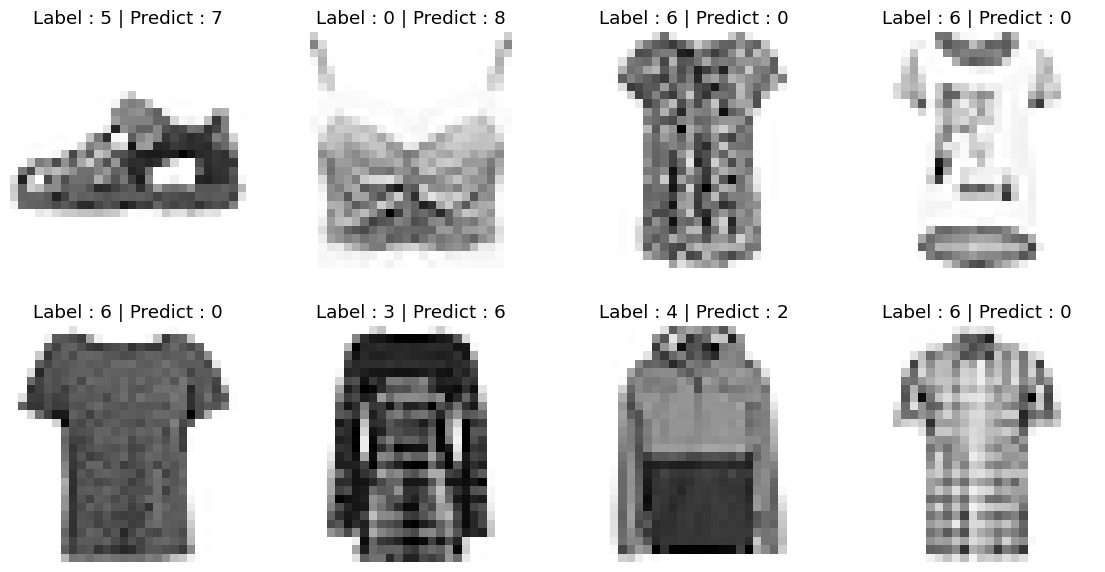

In [ ]:
predicted_result = []
# Y_test = []
device_model.eval()
with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device)
        y = y.to(device)
        predicted_labels = torch.argmax(device_model(x), dim=1)

predicted_labels = predicted_labels.cpu().detach().numpy()
y = y.cpu().detach().numpy()

"""Check the wrong results"""
wrong_result = []
for n in range(0, len(y)):
    if predicted_labels[n] != y[n]: # prediction 와 label이 다를 때만 몇 번째 data인지 기록 -> wrong_results=[201, 503, 1100, ... ]
        wrong_result.append(n)

print('The number of wrong answers: ' + str(len(wrong_result)) + ' / 10000')


""" Visualize the wrong answers """
samples = random.choices(population=wrong_result, k = 8)
plt.figure(figsize=(14,7))
for idx, n in enumerate(samples):
    plt.subplot(2,4,idx+1)
    plt.imshow(test_ds[n][0].reshape(28, 28), cmap='Greys', interpolation='nearest')
    plt.title("Label : " + str(y[n]) + ' | Predict : ' + str(predicted_labels[n]))
    plt.axis('off')

In [ ]:
# 정확도 파일로 저장
save_acc_list = []
'''save the accuracy at every iteration'''
for i in range(len(acc_list)):
    save_acc_list.append(acc_list[i].to('cpu').numpy())
save_list = pd.DataFrame(save_acc_list)

save_list.to_excel("./F-MNIST_QD_seed_"+str(seed)+".xlsx", header=False, index=False)

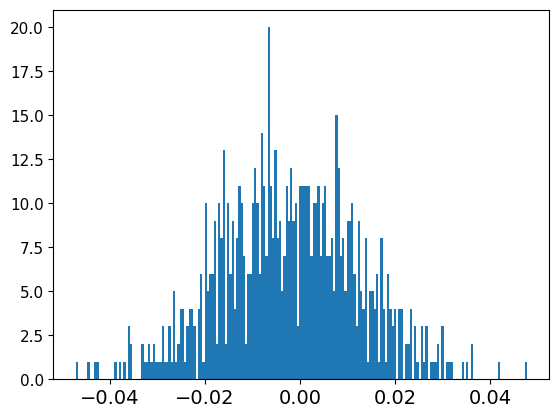

In [ ]:
# 학습 완료 후 fc1 weight histogram
with torch.no_grad():
    '''mapping differential new weights to device_model'''
    for name, p in device_model.named_parameters():
        if name == 'fc1.weight':
            plt.hist(p[0].data.to('cpu'), bins=200)
            plt.show()

<ipython-input-32-b18c0c6eeaa6>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/best_pt.pt")


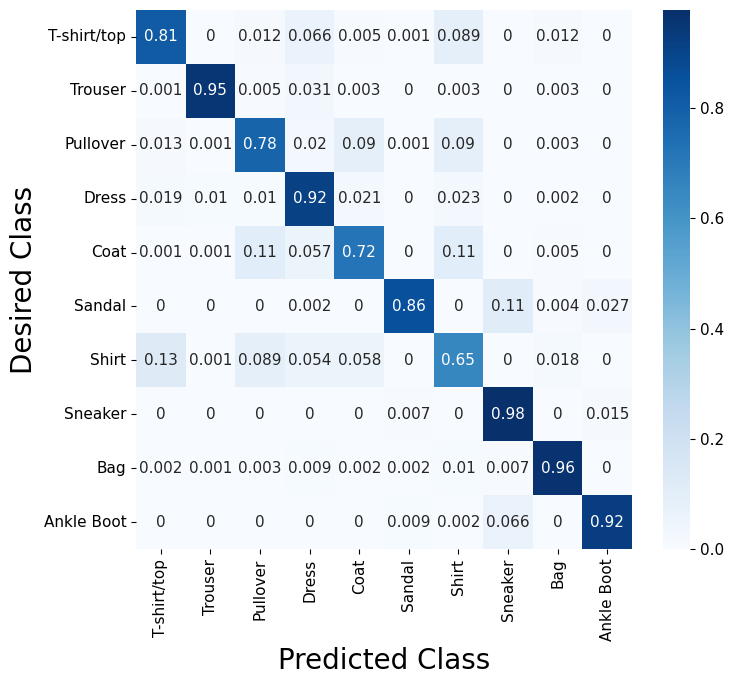

In [ ]:
# cpnfusion matrix 그리기

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# def createConfusionMatrix(loader):
#     y_pred = [] # save predction
#     y_true = [] # save ground truth

#     # iterate over data
#     for inputs, labels in loader:
#         output = net(inputs)  # Feed Network

#         output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
#         y_pred.extend(output)  # save prediction

#         labels = labels.data.cpu().numpy()
#         y_true.extend(labels)  # save ground truth

#     # constant for classes
#     classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

#     # Build confusion matrix
#     cf_matrix = confusion_matrix(y_true, y_pred)
#     df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in classes],
#                          columns=[i for i in classes])
#     plt.figure(figsize=(12, 7))
#     return sn.heatmap(df_cm, annot=True).get_figure()


y_pred = []
y_true = []

checkpoint = torch.load("/content/best_pt.pt")
device_model.cpu().load_state_dict(checkpoint)


# iterate over test data
for inputs, labels in test_dl:
        output = device_model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8,7))
plt.rc('font', size=11) #rc: runtime configuration

sn.heatmap(df_cm, annot=True, cmap="Blues")
# plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.xlabel('Predicted Class', fontsize=20)
plt.ylabel('Desired Class', fontsize=20)

plt.savefig('output.pdf', bbox_inches='tight')